# Task3: A Real Problem
This notebook is code and explanation about Gotham City cell phone tower problem.


## 1. Explain why this is a problem that can be easily mapped to the UD-MIS problem.
The possible cell phone tower locations can be directly mapped to the graph vertices. There will be an edge between two vertices if the distance between two vertices are less than 1 (i.e. within the unit disk).  
The roblem have constraints such as 1) the cell phone tower signal range do not overlap (so as to minimize the cost of building them), 2) maximize the area that is covered by the signal of phone towers.
This is same constrains as UD-MIS problem.

## 2. Slove Gotham City's problem
We will use Metropolis-Hastings algorithm to solve UD-MIS problem.  
Most of codes are same with [Task1.ipynb](./Task1.ipynb)

# Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abstract_udmis import AbstractUDMIS

%matplotlib inline

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

In [2]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        # vertex list of connected with vertex i
        connections = np.where(self.edges[i,:])[0]
        # number of occupied vertexes which connected with vertex i
        num_adjacent_occupied = self.occupations[connections].sum()
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        

### Input Vertex as possible location of Gotham City's cell phone tower. 

In [3]:
u = 1.35
# number of possible cell phone tower location
V = 12

# possible cell phone tower location
graph = [(1.19,4.25),   # 1
        (2.71,3.48),    # 2
        (1.19,3.51),    # 3
        (2.,3.38),      # 4
        (1.12,2.86),    # 5
        (1.70,2.42),    # 6
        (2.36,2.54),    # 7
        (1.52,1.48),    # 8
        (2.15,1.54),    # 9
        (2.14,1.87),    # 10
        (1.72,0.86),    # 11
        (2.29,0.87)     # 12
        ]

udmis = UDMIS(u, graph)

12


## All tower location and range
![all_tower](figures/all_tower.jpg)

In [4]:
N = 300
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))
E_ = []
for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)
    E_.append(E)
    
    # if t % 10 == 0:
    #     print(udmis.occupations)

print("stable energy: ",E_[-1])

stable energy:  -5.0


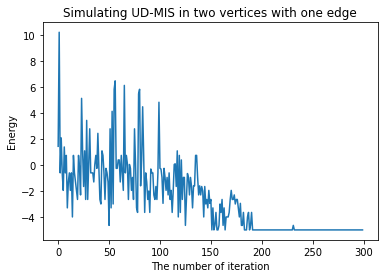

In [5]:
t = np.arange(N)
plt.title("Simulating UD-MIS in two vertices with one edge")
plt.xlabel("The number of iteration")
plt.ylabel("Energy")
plt.plot(t,E_)
plt.show()

In [6]:
print("Gotham City should build cell phone tower at ", np.where(udmis.occupations == 1)[0] + 1, "location")

Gotham City should build cell phone tower at  [ 1  4  5 10 12] location


## 3. Should Bruce pay for a few more cell phone towers to make sure that more of Gotham city has cell phone service?
To completely avoid any overlapping signals (and hence to minimize the cose), there should be no more cell phone towers. How,ever if Bruce is willing to pay some more money, then he should try to build a few more phone towers where there is large gap between two unit disks. For example, Bruce might consider building phone towers at locations 3 and 6. These locations can be determined by looking at the solution with the second lowest energy cost, or the third lowest energy cost, depending on how much he is willing to pay more.

## Selected [1 4 5 10 12] tower location and range
![selected_tower](figures/selected_tower.jpg)